<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
# Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # For CPU inference

In [2]:
 # dynamically grow the memory used on the GPU
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True 
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
# Import all necessary libraries.
import numpy as np
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [4]:
# Import license plate recognition tools.
from NomeroffNet import  filters
from NomeroffNet import  RectDetector
from NomeroffNet import  TextDetector
from NomeroffNet import  OptionsDetector
from NomeroffNet import  Detector
from NomeroffNet import  textPostprocessing

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    }
})

# Initialize npdetector with default configuration file.
nnet = Detector()
nnet.loadModel(NOMEROFF_NET_DIR)

Config '/home/www/nomeroff-net/./NomeroffNet/configs/centermask2/numberplates/centermask_numberplate_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


/home/www/nomeroff-net/centermask2/centermask/modeling/fcos/fcos_outputs.py:402: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  per_candidate_nonzeros = per_candidate_inds.nonzero()


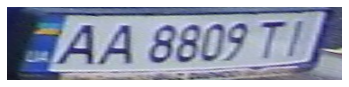

['eu_ua_2015']
[1]
['AA8809TI']


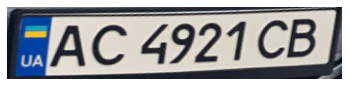

['eu_ua_2015']
[1]
['AC4921CB']


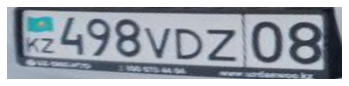

['kz']
[1]
['438VDZ08']


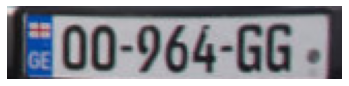

['ge']
[1]
['OO964GG']


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


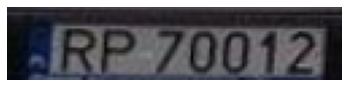

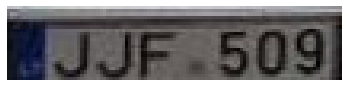

['eu', 'eu']
[1, 1]
['RP70012', 'JJF509']


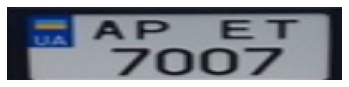

['kz']
[2]
['MFW0']


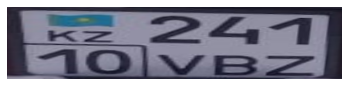

['kz']
[2]
['2411O6']


In [5]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'images/*'

imgs = [mpimg.imread(img_path) for img_path in glob.glob(rootDir)]
        
cv_imgs_masks = nnet.detect_mask(imgs)

for img, cv_img_masks in zip(imgs, cv_imgs_masks):    
    # Detect points.
    arrPoints = rectDetector.detect(cv_img_masks)
            
    # Detect points.
    arrPoints = rectDetector.detect(cv_img_masks)

    # cut zones
    zones = rectDetector.get_cv_zonesBGR(img, arrPoints)
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    for zone, points in zip(toShowZones, arrPoints):
        plt.axis("off")
        plt.imshow(zone)
        plt.show()

    # find standart
    regionIds, stateIds, countLines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    print(regionNames)
    print(countLines)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, countLines)
    textArr = textPostprocessing(textArr, regionNames)
    print(textArr)